# **1. Install packages**

In [8]:
%%capture
!pip install torchinfo transformers

# **2. Import libraries**

In [9]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

# Preprocessing
from sklearn.model_selection import train_test_split as tts

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

# Transformers for VLM
from transformers import CLIPProcessor, CLIPModel

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# os
import os

# OrderedDict
from collections import OrderedDict

# tqdm
from tqdm.auto import tqdm

# Path
from pathlib import Path

# random
import random

# typing
from typing import Dict, List

# warnings
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
SEED = 123
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# **3. Load data and EDA**

# **4. Image Preprocessing**

This section defines functions for image preprocessing, including resizing, normalization, and data augmentation.

In [10]:
import torchvision.transforms as transforms

def get_image_transforms(image_size=(224, 224), is_train=True):
    if is_train:
        return transforms.Compose([
            transforms.Resize(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        return transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# **5. Text Preprocessing**

This section defines functions for text preprocessing, including tokenization, lowercasing, and stop word removal.

In [11]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords if not already downloaded
import nltk
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenization
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]  # Stop word removal
    return ' '.join(filtered_tokens)

# **6. Dataset and DataLoader with Preprocessing**

This section integrates the image and text preprocessing steps into a custom PyTorch Dataset.

In [12]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class PotatoLeafDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, text_data=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.text_data = text_data

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        if self.text_data is not None:
            text = self.text_data[idx]
            processed_text = preprocess_text(text) # Apply text preprocessing
            return image, processed_text, label
        else:
            return image, label

# Example usage (assuming you have image_paths, labels, and optionally text_data)
# For demonstration, let's create dummy data:
# from sklearn.model_selection import train_test_split
# from torch.utils.data import DataLoader

# # Assuming IMAGE_PATH_LIST and classes are already defined from previous sections
# # Create dummy labels for demonstration
# all_labels = [img_path.parent.name for img_path in IMAGE_PATH_LIST]
# label_to_idx = {cls_name: i for i, cls_name in enumerate(sorted(list(set(all_labels))))}
# encoded_labels = [label_to_idx[label] for label in all_labels]

# # Split data (example)
# train_img_paths, test_img_paths, train_labels, test_labels = train_test_split(
# #     IMAGE_PATH_LIST, encoded_labels, test_size=0.2, random_state=SEED, stratify=encoded_labels
# # )

# # Get transforms
# train_transforms = get_image_transforms(is_train=True)
# test_transforms = get_image_transforms(is_train=False)

# # Create datasets
# train_dataset = PotatoLeafDataset(train_img_paths, train_labels, transform=train_transforms)
# test_dataset = PotatoLeafDataset(test_img_paths, test_labels, transform=test_transforms)

# # Create DataLoaders
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [13]:
# Total Images
IMAGE_PATH = Path("/kaggle/input/potato-leaf-disease-dataset/Potato Leaf Disease Dataset in Uncontrolled Environment")

IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*.jpg"))

print(f'Total Images = {len(IMAGE_PATH_LIST)}')

Total Images = 1885


In [14]:
# number of images per class.
classes = os.listdir(IMAGE_PATH)
classes = sorted(classes)

print("**" * 20)
print(" " * 10, f"Total Classes = {len(classes)}")
print("**" * 20)

for c in classes:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, c)).glob("*.jpg"))
    print(f"* {c}: {len(total_images_class)} images")

****************************************
           Total Classes = 7
****************************************
* Bacteria: 342 images
* Fungi: 452 images
* Healthy: 175 images
* Nematode: 47 images
* Pest: 415 images
* Phytopthora: 151 images
* Virus: 303 images


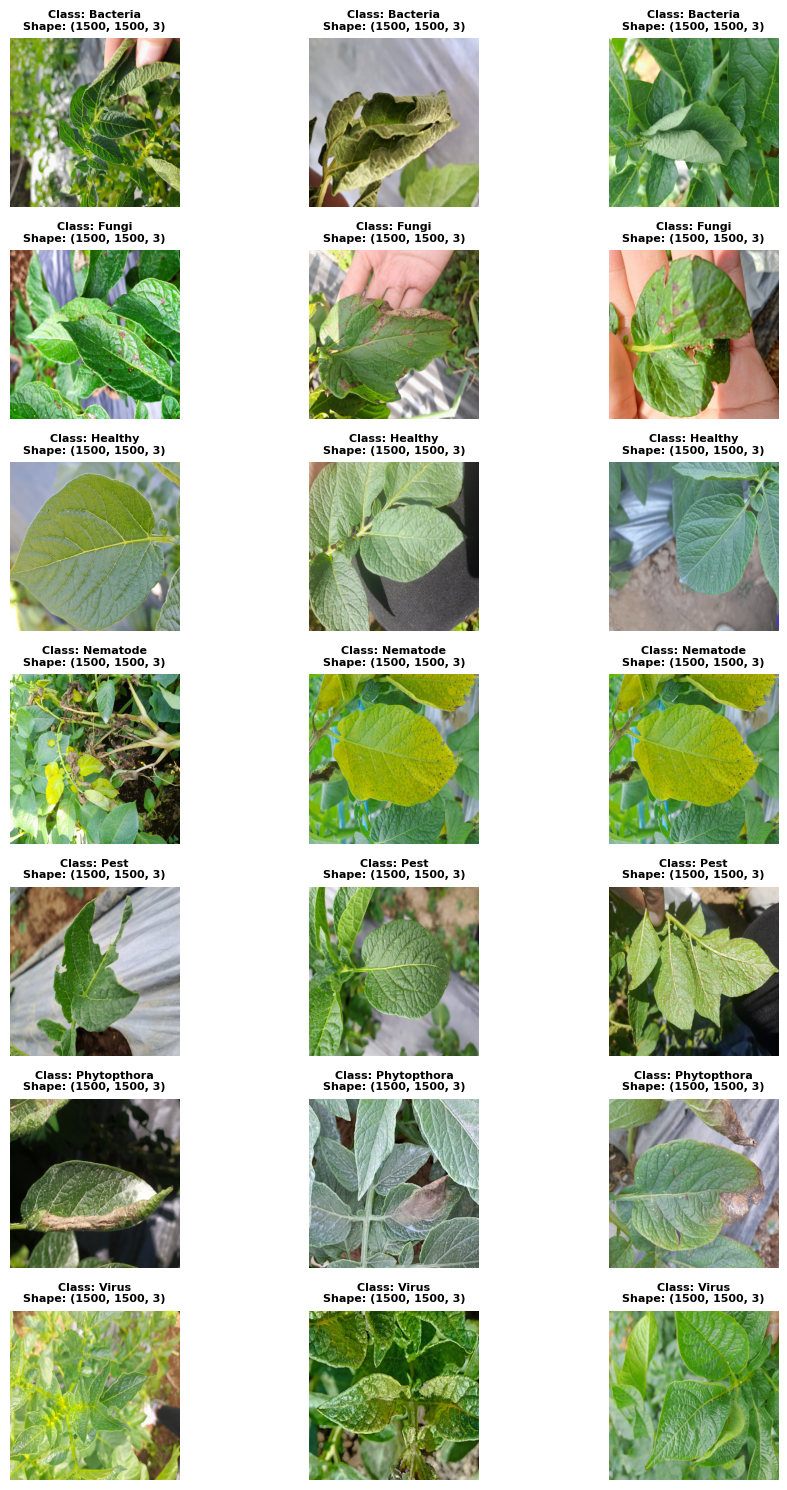

In [15]:
# We view some images for each class.
NUM_IMAGES = 3

fig, ax = plt.subplots(nrows = len(classes), ncols = NUM_IMAGES, figsize = (10,15))
p = 0
for c in classes:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, c)).glob("*.jpg"))
    images_selected = random.choices(total_images_class, k = NUM_IMAGES)
    
    for i,img_path in enumerate(images_selected):
        img_bgr = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_rgb)
        ax[p,i].axis("off")
        ax[p,i].set_title(f"Class: {c}\nShape: {img_rgb.shape}", fontsize = 8, fontweight = "bold", color = "black")
        
    p += 1
    
fig.tight_layout()
plt.show()

# **4. Preprocessing**

Let's create a dataframe with two columns:

- the first **path** call will store the paths of the images.
- the second call **label** that will contain the labels of each image.

In [16]:
images_path = [None] * len(IMAGE_PATH_LIST)
labels = [None] * len(IMAGE_PATH_LIST)

for i,image_path in enumerate(IMAGE_PATH_LIST):
    images_path[i] = image_path
    labels[i] = image_path.parent.stem
    
df_path_and_label = pd.DataFrame({'path':images_path, 
                                  'label':labels})
df_path_and_label.head()

,path,label
0,/kaggle/input/potato-leaf-disease-dataset/Pota...,Nematode
1,/kaggle/input/potato-leaf-disease-dataset/Pota...,Nematode
2,/kaggle/input/potato-leaf-disease-dataset/Pota...,Nematode
3,/kaggle/input/potato-leaf-disease-dataset/Pota...,Nematode
4,/kaggle/input/potato-leaf-disease-dataset/Pota...,Nematode


Now we have to divide our dataframe into 3 parts:

- **train = 70%**
- **valid = 15%**
- **test = 15%**

In [9]:
df_train, df_rest = tts(df_path_and_label, 
                        test_size = 0.3, 
                        random_state = SEED, 
                        stratify = df_path_and_label["label"])

df_val, df_test = tts(df_rest, 
                      test_size = 0.5, 
                      random_state = SEED, 
                      stratify = df_rest["label"])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [18]:
# We have to define the mapping of the classes to convert the labels to numbers.
label_map = dict(zip(classes, range(0, len(classes))))
label_map

{'Bacteria': 0,
 'Fungi': 1,
 'Healthy': 2,
 'Nematode': 3,
 'Pest': 4,
 'Phytopthora': 5,
 'Virus': 6}

# **5. Create Text Prompts for Vision-Language Model**

For our vision-language model (CLIP), we need to create text prompts for each disease category. These prompts will help the model understand the context of each image.

In [19]:
# Create text prompts for each class
text_prompts = {
    "Bacteria": "a potato leaf infected with bacterial disease",
    "Fungi": "a potato leaf infected with fungal disease",
    "Healthy": "a healthy potato leaf with no disease",
    "Nematode": "a potato leaf infected with nematode disease",
    "Pest": "a potato leaf damaged by pests",
    "Phytopthora": "a potato leaf infected with phytopthora disease",
    "Virus": "a potato leaf infected with viral disease"
}

for class_name, prompt in text_prompts.items():
    print(f"{class_name}: {prompt}")

Bacteria: a potato leaf infected with bacterial disease
Fungi: a potato leaf infected with fungal disease
Healthy: a healthy potato leaf with no disease
Nematode: a potato leaf infected with nematode disease
Pest: a potato leaf damaged by pests
Phytopthora: a potato leaf infected with phytopthora disease
Virus: a potato leaf infected with viral disease


# **6. Custom Dataset and Model Architecture**

Now we'll define our custom dataset and model architecture for fine-tuning CLIP on potato leaf disease classification.

In [20]:
# Load CLIP processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [21]:
# Custom dataset for CLIP model
class CLIPPotatoDataset(Dataset):
    def __init__(self, df, processor, text_prompts, label_map):
        """
        Dataset for CLIP-based potato leaf disease classification
        
        Args:
            df: DataFrame with image paths and labels
            processor: CLIP processor for image and text preprocessing
            text_prompts: Dictionary mapping class names to text descriptions
            label_map: Dictionary mapping class names to numeric indices
        """
        self.df = df
        self.processor = processor
        self.text_prompts = text_prompts
        self.label_map = label_map
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        """
        Get a single sample from the dataset
        """
        row = self.df.iloc[idx]
        image_path = row['path']
        label = row['label']
        label_id = self.label_map[label]
        
        # Load image
        image = Image.open(image_path).convert("RGB")
        
        # Get text prompt for this class
        text = self.text_prompts[label]
        
        # Process inputs through CLIP processor
        # Don't squeeze - let the dataloader handle batching
        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=77  # CLIP's max token length
        )
        
        # Remove batch dimension added by the processor
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        
        # Add label
        inputs['labels'] = torch.tensor(label_id)
        
        return inputs

In [22]:
# Custom collate function for batching
def collate_fn(batch):
    """
    Custom collate function to handle the dictionary format of our dataset items
    
    Args:
        batch: List of dictionaries from dataset __getitem__
        
    Returns:
        Batched dictionary with properly stacked tensors
    """
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    
    return {
        'pixel_values': pixel_values,
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

In [10]:
# Create datasets
train_dataset = CLIPPotatoDataset(df_train, processor, text_prompts, label_map)
valid_dataset = CLIPPotatoDataset(df_val, processor, text_prompts, label_map)
test_dataset = CLIPPotatoDataset(df_test, processor, text_prompts, label_map)

NameError: name 'CLIPPotatoDataset' is not defined

In [24]:
# Create dataloaders with custom collate function
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

valid_dataloader = DataLoader(
    valid_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

# **7. Vision-Language Model Architecture**

Now we'll create a custom model that uses CLIP as the backbone and adds a classification head for fine-tuning.

In [25]:
# GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [26]:
# Fine-tuning CLIP for potato leaf disease classification
class CLIPFineTuner(nn.Module):
    def __init__(self, num_classes, unfreeze_layers=0):
        """
        Initialize the CLIP fine-tuning model
        
        Args:
            num_classes: Number of target classes for classification
            unfreeze_layers: Number of transformer layers to unfreeze from the end (0 means all frozen)
        """
        super(CLIPFineTuner, self).__init__()
        
        # Load the pretrained CLIP model
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # Freeze base CLIP model by default
        for param in self.clip.parameters():
            param.requires_grad = False
            
        # Selectively unfreeze some layers if specified
        if unfreeze_layers > 0:
            # Unfreeze the visual encoder's last n layers
            for i, layer in enumerate(self.clip.vision_model.encoder.layers):
                if i >= len(self.clip.vision_model.encoder.layers) - unfreeze_layers:
                    for param in layer.parameters():
                        param.requires_grad = True
        
        # Get the projection dimension from CLIP config
        projection_dim = self.clip.config.projection_dim
        
        # Create new classification head with proper dimensions
        self.classifier = nn.Sequential(
            nn.Linear(projection_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, batch):
        """
        Forward pass through the model
        
        Args:
            batch: Dictionary containing 'pixel_values', 'input_ids', and 'attention_mask'
        
        Returns:
            logits: Classification logits
        """
        # Extract inputs from batch
        pixel_values = batch['pixel_values']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        
        # Get image features from CLIP
        vision_outputs = self.clip.vision_model(pixel_values=pixel_values)
        image_embeds = vision_outputs[1]  # Use pooled output
        image_features = self.clip.visual_projection(image_embeds)
        
        # Get text features from CLIP
        text_outputs = self.clip.text_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        text_embeds = text_outputs[1]  # Use pooled output
        text_features = self.clip.text_projection(text_embeds)
        
        # Normalize features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        # Combine features using a more sophisticated approach than simple averaging
        # Weighted combination (70% image, 30% text)
        combined_features = image_features * 0.7 + text_features * 0.3
        
        # Pass through classifier
        logits = self.classifier(combined_features)
        
        return logits

In [27]:
# Initialize model with selective unfreezing of the last 2 layers
model = CLIPFineTuner(num_classes=len(classes), unfreeze_layers=2).to(device)

# Print model summary
# Note: We can't use torchinfo.summary directly with our model due to the dictionary input
print(f"Model initialized with {len(classes)} output classes")
print(f"CLIP projection dimension: {model.clip.config.projection_dim}")

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of total)")

Model initialized with 7 output classes
CLIP projection dimension: 512
Trainable parameters: 14,441,991 (9.53% of total)


# **8. Training Functions**

Let's define the functions needed for training and validation.

In [28]:
# Training function
def train_step(model, dataloader, loss_fn, optimizer, device):
    """
    Training step function with proper error handling
    
    Args:
        model: The CLIP fine-tuner model
        dataloader: DataLoader for training data
        loss_fn: Loss function
        optimizer: Optimizer
        device: Device to run training on
        
    Returns:
        train_loss, train_accuracy: Average loss and accuracy for this epoch
    """
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    total_batches = len(dataloader)
    
    for batch in dataloader:
        try:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch['labels']
            
            # Forward pass
            optimizer.zero_grad()
            logits = model(batch)
            loss = loss_fn(logits, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Calculate metrics
            train_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            train_accuracy += (preds == labels).float().mean().item()
            
        except Exception as e:
            print(f"Error in training batch: {e}")
            continue
    
    # Return average loss and accuracy
    return train_loss / total_batches, train_accuracy / total_batches

In [29]:
# Validation function
def valid_step(model, dataloader, loss_fn, device):
    """
    Validation step function with proper error handling
    
    Args:
        model: The CLIP fine-tuner model
        dataloader: DataLoader for validation data
        loss_fn: Loss function
        device: Device to run validation on
        
    Returns:
        valid_loss, valid_accuracy: Average loss and accuracy for validation
    """
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0.0
    total_batches = len(dataloader)
    
    with torch.no_grad():
        for batch in dataloader:
            try:
                # Move batch to device
                batch = {k: v.to(device) for k, v in batch.items()}
                labels = batch['labels']
                
                # Forward pass
                logits = model(batch)
                loss = loss_fn(logits, labels)
                
                # Calculate metrics
                valid_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                valid_accuracy += (preds == labels).float().mean().item()
                
            except Exception as e:
                print(f"Error in validation batch: {e}")
                continue
    
    # Return average loss and accuracy
    return valid_loss / total_batches, valid_accuracy / total_batches


### Explanation for Code Cell 33

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



In [30]:
def save_checkpoint(filename, model, loss, epoch, optimizer, metric):
    """
    Save model checkpoint
    
    Args:
        filename: Path to save the checkpoint
        model: Model to save
        loss: Current loss value
        epoch: Current epoch
        optimizer: Optimizer state
        metric: Current metric value
    """
    state = {
        "filename": filename, 
        "model": model.state_dict(), 
        "loss": loss, 
        "epoch": epoch, 
        "optimizer": optimizer.state_dict(), 
        "metric": metric
    }
    
    torch.save(state, filename)


### Explanation for Code Cell 34

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



In [31]:
# Main training loop
def train_model(model, train_dataloader, valid_dataloader, loss_fn, optimizer, device, epochs=10):
    """
    Main training loop with validation
    
    Args:
        model: Model to train
        train_dataloader: DataLoader for training data
        valid_dataloader: DataLoader for validation data
        loss_fn: Loss function
        optimizer: Optimizer
        device: Device to run training on
        epochs: Number of epochs to train
        
    Returns:
        results: Dictionary containing training and validation metrics
    """
    results = {
        "train_loss": [],
        "train_accuracy": [],
        "valid_loss": [],
        "valid_accuracy": []
    }
    
    best_valid_loss = float("inf")
    
    for epoch in tqdm(range(epochs)):
        # Training
        train_loss, train_accuracy = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )
        
        # Validation
        valid_loss, valid_accuracy = valid_step(
            model=model,
            dataloader=valid_dataloader,
            loss_fn=loss_fn,
            device=device
        )
        
        # Save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            file_name = "best_vlm_model.pth"
            save_checkpoint(file_name, model, best_valid_loss, epoch, optimizer, valid_accuracy)
            print(f"✅ New best model saved at epoch {epoch + 1}")
            
        # Print progress
        print(f"Epoch: {epoch + 1} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Train Accuracy: {train_accuracy:.4f} | "
              f"Valid Loss: {valid_loss:.4f} | "
              f"Valid Accuracy: {valid_accuracy:.4f}")
        
        # Store results
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["valid_loss"].append(valid_loss)
        results["valid_accuracy"].append(valid_accuracy)
    
    return results


### Explanation for Code Cell 35

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



# **9. Training the Vision-Language Model**

In [32]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

# Only optimize the classifier parameters and any unfrozen layers
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)


### Explanation for Code Cell 37

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



In [33]:
# Training!!!
EPOCHS = 25

torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

MODEL_RESULTS = train_model(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=EPOCHS
)

  0%|          | 0/25 [00:00<?, ?it/s]

✅ New best model saved at epoch 1
Epoch: 1 | Train Loss: 1.9092 | Train Accuracy: 0.2889 | Valid Loss: 1.8767 | Valid Accuracy: 0.5511
✅ New best model saved at epoch 2
Epoch: 2 | Train Loss: 1.8537 | Train Accuracy: 0.5901 | Valid Loss: 1.8303 | Valid Accuracy: 0.6596
✅ New best model saved at epoch 3
Epoch: 3 | Train Loss: 1.8062 | Train Accuracy: 0.6986 | Valid Loss: 1.7872 | Valid Accuracy: 0.7073
✅ New best model saved at epoch 4
Epoch: 4 | Train Loss: 1.7578 | Train Accuracy: 0.7681 | Valid Loss: 1.7459 | Valid Accuracy: 0.7227
✅ New best model saved at epoch 5
Epoch: 5 | Train Loss: 1.7038 | Train Accuracy: 0.8198 | Valid Loss: 1.6982 | Valid Accuracy: 0.7891
✅ New best model saved at epoch 6
Epoch: 6 | Train Loss: 1.6416 | Train Accuracy: 0.8876 | Valid Loss: 1.6461 | Valid Accuracy: 0.7578
✅ New best model saved at epoch 7
Epoch: 7 | Train Loss: 1.5752 | Train Accuracy: 0.9233 | Valid Loss: 1.5894 | Valid Accuracy: 0.8279
✅ New best model saved at epoch 8
Epoch: 8 | Train Loss


### Explanation for Code Cell 38

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



# **10. Visualizing Training Results**

In [34]:
# Function to plot the loss and metric during each training epoch.
def loss_metric_curve_plot(model_results):
    
    train_loss = model_results["train_loss"]
    valid_loss = model_results["valid_loss"]
    
    train_accuracy = model_results["train_accuracy"]
    valid_accuracy = model_results["valid_accuracy"]
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    axes = axes.flat
    
    # Plot loss
    axes[0].plot(train_loss, color="red", label="Train")
    axes[0].plot(valid_loss, color="blue", label="Valid")
    axes[0].set_title("CrossEntropyLoss", fontsize=12, fontweight="bold", color="black")
    axes[0].set_xlabel("Epochs", fontsize=10, fontweight="bold", color="black")
    axes[0].set_ylabel("Loss", fontsize=10, fontweight="bold", color="black")
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Plot accuracy
    axes[1].plot(train_accuracy, color="red", label="Train")
    axes[1].plot(valid_accuracy, color="blue", label="Valid")
    axes[1].set_title("Accuracy", fontsize=12, fontweight="bold", color="black")
    axes[1].set_xlabel("Epochs", fontsize=10, fontweight="bold", color="black")
    axes[1].set_ylabel("Score", fontsize=10, fontweight="bold", color="black")
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    fig.tight_layout()
    plt.show()


### Explanation for Code Cell 40

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



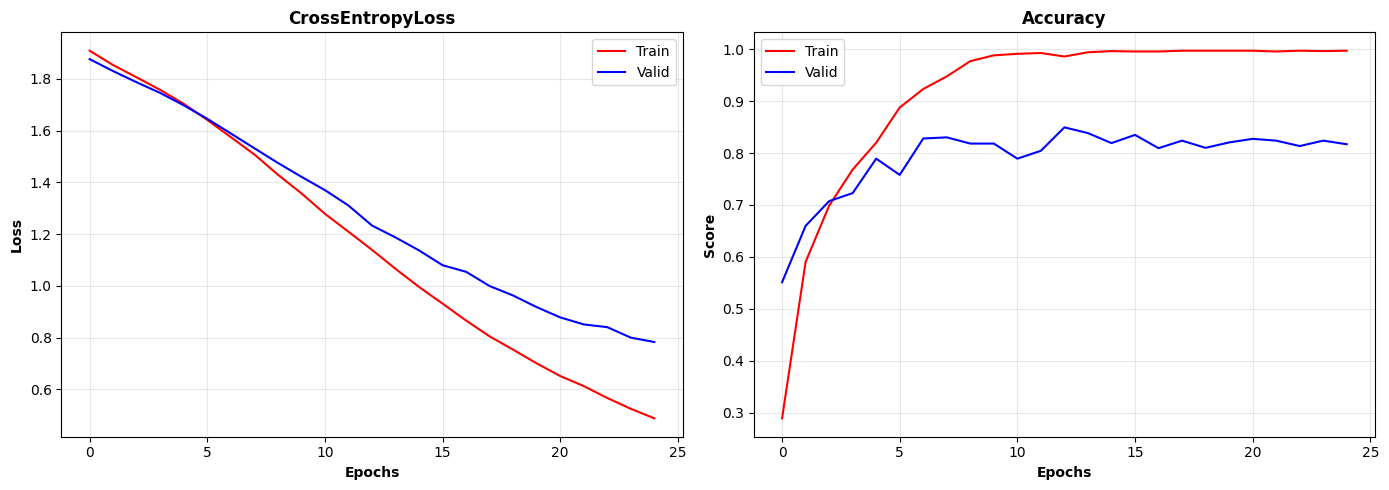

In [35]:
loss_metric_curve_plot(MODEL_RESULTS)


### Explanation for Code Cell 41

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



In [36]:
# Let's load the best model.
checkpoint_path = "best_vlm_model.pth"
checkpoint = torch.load(checkpoint_path)


### Explanation for Code Cell 42

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



In [37]:
# Now let's look at the smallest loss, its metric and when it occurred.
print(f'Best Loss: {checkpoint["loss"]:.4f}')
print(f'Epoch: {checkpoint["epoch"] + 1}')
print(f'Best Accuracy: {checkpoint["metric"]:.4f}')

Best Loss: 0.7833
Epoch: 25
Best Accuracy: 0.8169



### Explanation for Code Cell 43

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



# **11. Evaluating on Test Set**

In [38]:
# We define the model again with its respective modification.
loaded_model = CLIPFineTuner(num_classes=len(classes), unfreeze_layers=2)
loaded_model.load_state_dict(checkpoint["model"])

# We now infer
loaded_model.to(device)
loaded_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']
        
        # Forward pass
        logits = loaded_model(batch)
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

  0%|          | 0/9 [00:00<?, ?it/s]


### Explanation for Code Cell 45

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



# **12. Metrics**

- **Accuracy**

In [39]:
test_accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy = {test_accuracy:.4f}')

Accuracy = 0.8410



### Explanation for Code Cell 48

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



- **Confusion Matrix**

In [40]:
confusion_matrix_test = confusion_matrix(all_labels, all_preds)


### Explanation for Code Cell 50

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



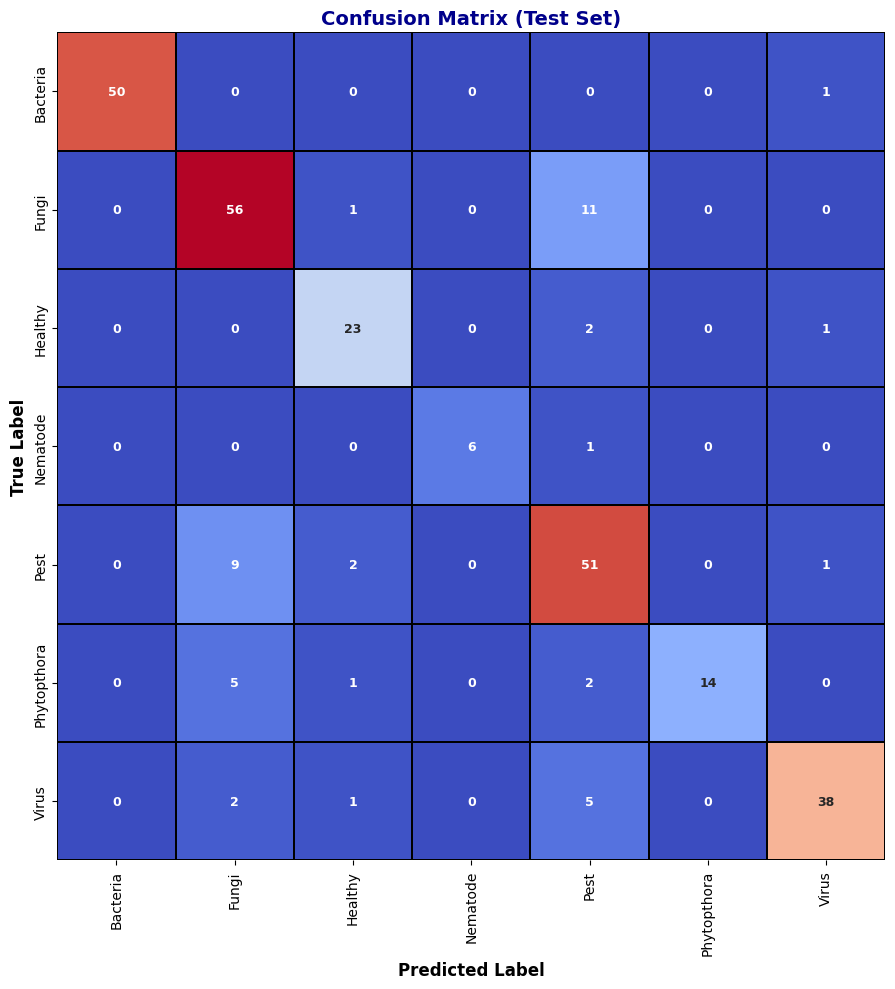

In [41]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(
    confusion_matrix_test, 
    cmap='coolwarm', 
    annot=True, 
    annot_kws={"fontsize": 9, "fontweight": "bold"}, 
    linewidths=1.2, 
    linecolor="black", 
    square=True, 
    xticklabels=classes, 
    yticklabels=classes, 
    cbar=False,
    ax=ax
)
ax.set_title("Confusion Matrix (Test Set)", fontsize=14, fontweight="bold", color="darkblue")
ax.set_xlabel("Predicted Label", fontsize=12, fontweight="bold")
ax.set_ylabel("True Label", fontsize=12, fontweight="bold")
ax.tick_params('x', rotation=90)
plt.tight_layout()
plt.show()


### Explanation for Code Cell 51

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



- **Classification Report**

In [42]:
print(classification_report(all_labels, all_preds, target_names=classes))

              precision    recall  f1-score   support

    Bacteria       1.00      0.98      0.99        51
       Fungi       0.78      0.82      0.80        68
     Healthy       0.82      0.88      0.85        26
    Nematode       1.00      0.86      0.92         7
        Pest       0.71      0.81      0.76        63
 Phytopthora       1.00      0.64      0.78        22
       Virus       0.93      0.83      0.87        46

    accuracy                           0.84       283
   macro avg       0.89      0.83      0.85       283
weighted avg       0.85      0.84      0.84       283




### Explanation for Code Cell 53

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



# **13. Pesticide Recommendation System**

Now we'll create a system that provides pesticide recommendations based on the predicted disease class.

In [43]:
# %%capture.txt content (assuming it's already run)
# ... (all your existing imports from cell 1) ...
# Transformers for T2T model
from transformers import T5TokenizerFast, T5ForConditionalGeneration, AdamW, get_scheduler

# ... (rest of your code from cell 1 to cell 31) ...

# --- START OF NEW CODE FOR TEXT-TO-TEXT MODEL ---

# 32. (Existing pesticide recommendations - this will be our T2T training data source)
pesticide_recommendations = {
    "Bacteria": {
        "disease_info": "Bacterial diseases in potato plants are typically caused by pathogens like Ralstonia solanacearum, Pectobacterium spp., or Dickeya spp. These bacteria cause wilting, rotting, and can lead to significant yield losses.",
        "pesticides": [
            "Copper-based bactericides (e.g., Copper Hydroxide, Copper Oxychloride)",
            "Streptomycin sulfate (where legally permitted)",
            "Kasugamycin-based products"
        ],
        "application": "Apply as a foliar spray every 7-10 days during periods of disease pressure. Ensure good coverage of all plant surfaces.",
        "cultural_practices": [
            "Use certified disease-free seed potatoes",
            "Practice crop rotation (3-4 year cycle)",
            "Improve field drainage to reduce soil moisture",
            "Sanitize all equipment between fields",
            "Remove and destroy infected plants"
        ]
    },
    "Fungi": {
        "disease_info": "Fungal diseases in potatoes include Early Blight (Alternaria solani), Late Blight (Phytophthora infestans), and various other fungal pathogens that cause leaf spots, wilting, and tuber rot.",
        "pesticides": [
            "Mancozeb-based fungicides",
            "Chlorothalonil products",
            "Azoxystrobin-based fungicides",
            "Propiconazole products",
            "Copper-based fungicides"
        ],
        "application": "Begin applications when plants are 6-8 inches tall or when disease first appears. Repeat at 7-10 day intervals depending on disease pressure and weather conditions.",
        "cultural_practices": [
            "Use disease-resistant varieties when available",
            "Ensure proper plant spacing for good air circulation",
            "Avoid overhead irrigation if possible",
            "Practice crop rotation",
            "Remove plant debris after harvest"
        ]
    },
    "Healthy": {
        "disease_info": "Your potato plant appears healthy with no visible signs of disease or pest damage.",
        "pesticides": [
            "No pesticide treatment needed at this time"
        ],
        "application": "Continue regular monitoring for early signs of disease or pest problems.",
        "cultural_practices": [
            "Maintain regular watering schedule (1-2 inches per week)",
            "Apply balanced fertilizer according to soil test recommendations",
            "Monitor for early signs of disease or pest problems",
            "Practice good field sanitation",
            "Implement preventative fungicide program during high-risk periods"
        ]
    },
    "Nematode": {
        "disease_info": "Nematodes are microscopic worms that attack potato roots and tubers. Common species include root-knot nematodes (Meloidogyne spp.) and potato cyst nematodes (Globodera spp.).",
        "pesticides": [
            "Fluopyram-based nematicides",
            "Oxamyl products",
            "Biological controls with Paecilomyces lilacinus or Bacillus firmus",
            "Azadirachtin (neem-based products)"
        ],
        "application": "Apply pre-planting or at planting time according to product instructions. Some products may be applied through drip irrigation systems.",
        "cultural_practices": [
            "Practice long crop rotations (4+ years)",
            "Use certified nematode-free seed potatoes",
            "Plant nematode-resistant varieties when available",
            "Use cover crops like marigolds or sudangrass as biofumigants",
            "Solarize soil before planting in warmer climates"
        ]
    },
    "Pest": {
        "disease_info": "Common pests affecting potato plants include Colorado potato beetle, aphids, potato leafhoppers, and various caterpillars that feed on foliage.",
        "pesticides": [
            "Spinosad-based insecticides",
            "Imidacloprid or other neonicotinoids (systemic control)",
            "Pyrethroids for broad-spectrum control",
            "Bacillus thuringiensis (Bt) for caterpillar control",
            "Insecticidal soaps or neem oil for soft-bodied insects"
        ],
        "application": "Apply when pests are first observed. Target the undersides of leaves where many pests hide. Rotate insecticide classes to prevent resistance.",
        "cultural_practices": [
            "Monitor fields regularly for early pest detection",
            "Use row covers in early season",
            "Encourage beneficial insects by planting flowering plants nearby",
            "Practice crop rotation",
            "Remove volunteer potatoes that can harbor pests"
        ]
    },
    "Phytopthora": {
        "disease_info": "Phytophthora infestans causes Late Blight, one of the most destructive potato diseases. It can destroy entire fields in days under favorable conditions and was responsible for the Irish Potato Famine.",
        "pesticides": [
            "Metalaxyl or mefenoxam products (systemic)",
            "Chlorothalonil (protective)",
            "Copper-based fungicides",
            "Cymoxanil + famoxadone combinations",
            "Fluazinam products"
        ],
        "application": "Begin preventative applications before disease appears when conditions favor development (cool, wet weather). Apply every 5-7 days during high pressure periods.",
        "cultural_practices": [
            "Use Late Blight resistant varieties",
            "Plant certified disease-free seed potatoes",
            "Destroy all cull piles and volunteer potatoes",
            "Improve air circulation through proper plant spacing",
            "Avoid overhead irrigation or irrigate early in the day"
        ]
    },
    "Virus": {
        "disease_info": "Viral diseases in potatoes include Potato Virus Y (PVY), Potato Leafroll Virus (PLRV), and Potato Virus X (PVX). These are typically spread by aphids or through infected seed potatoes.",
        "pesticides": [
            "No direct chemical control for viral infections",
            "Insecticides to control aphid vectors (imidacloprid, thiamethoxam)",
            "Mineral oils to interfere with virus transmission"
        ],
        "application": "Apply insecticides early in the season to control virus vectors. Mineral oils should be applied weekly during periods of aphid activity.",
        "cultural_practices": [
            "Use certified virus-free seed potatoes",
            "Remove and destroy infected plants immediately",
            "Control weeds that may harbor viruses",
            "Plant virus-resistant varieties when available",
            "Isolate seed potato production from commercial fields"
        ]
    }
}


### Explanation for Code Cell 56

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



In [44]:
# 32.A Prepare data for Text-to-Text model
t2t_training_data = []
for disease, details in pesticide_recommendations.items():
    # Input prompt for the T2T model
    input_text = f"Recommend treatment for potato disease: {disease}"
    
    # Output text (the full recommendation)
    output_text = f"Disease Information: {details['disease_info']}\n\n"
    output_text += f"Recommended Pesticides/Treatments:\n" + "\n".join([f"- {p}" for p in details['pesticides']]) + "\n\n"
    output_text += f"Application Instructions: {details['application']}\n\n"
    output_text += f"Cultural Practices:\n" + "\n".join([f"- {cp}" for cp in details['cultural_practices']])
    
    t2t_training_data.append({"input": input_text, "output": output_text})

# Display a sample
print("Sample T2T Training Data:")
print(f"Input: {t2t_training_data[0]['input']}")
print(f"Output: {t2t_training_data[0]['output'][:300]}...") # Print partial output for brevity
print(f"\nTotal T2T training samples: {len(t2t_training_data)}")



Sample T2T Training Data:
Input: Recommend treatment for potato disease: Bacteria
Output: Disease Information: Bacterial diseases in potato plants are typically caused by pathogens like Ralstonia solanacearum, Pectobacterium spp., or Dickeya spp. These bacteria cause wilting, rotting, and can lead to significant yield losses.

Recommended Pesticides/Treatments:
- Copper-based bactericide...

Total T2T training samples: 7



### Explanation for Code Cell 57

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



In [45]:
# 32.B Define T2T Dataset and DataLoader
T2T_MODEL_NAME = "google/flan-t5-small" # A good small, instruction-tuned model
t2t_tokenizer = T5TokenizerFast.from_pretrained(T2T_MODEL_NAME)

class RecommendationDataset(Dataset):
    def __init__(self, data, tokenizer, max_input_length=128, max_target_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_text = item["input"]
        target_text = item["output"]

        # Tokenize inputs
        model_inputs = self.tokenizer(
            input_text,
            max_length=self.max_input_length,
            padding="max_length", # Pad to max_length
            truncation=True,
            return_tensors="pt"
        )

        # Tokenize targets (labels)
        labels = self.tokenizer(
            target_text,
            max_length=self.max_target_length,
            padding="max_length", # Pad to max_length
            truncation=True,
            return_tensors="pt"
        ).input_ids # We only need input_ids for labels

        # For T5, labels should not have padding tokens ignored by the loss function.
        # Replace pad_token_id with -100 (standard practice for Hugging Face T5 models)
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            "input_ids": model_inputs.input_ids.squeeze(0),
            "attention_mask": model_inputs.attention_mask.squeeze(0),
            "labels": labels.squeeze(0)
        }

t2t_dataset = RecommendationDataset(t2t_training_data, t2t_tokenizer)
# Since the dataset is tiny (7 samples), we can use a batch size that processes all of them, or a smaller one.
# For actual training, we'd shuffle. For this tiny dataset, it matters less.
t2t_dataloader = DataLoader(t2t_dataset, batch_size=4, shuffle=True) # Small batch size



### Explanation for Code Cell 58

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



# **14. Testing with Your Own Images**

Now you can test the model with your own potato leaf images and get pesticide recommendations based on the predicted disease.

In [46]:
# 32.C Define and Train the T2T Model
t2t_model = T5ForConditionalGeneration.from_pretrained(T2T_MODEL_NAME).to(device)

# Training parameters
t2t_optimizer = AdamW(t2t_model.parameters(), lr=5e-5)
t2t_epochs = 50 # More epochs because the dataset is tiny, it will memorize
num_training_steps = t2t_epochs * len(t2t_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=t2t_optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

print(f"\nStarting T2T model training for {t2t_epochs} epochs...")
t2t_model.train()
for epoch in range(t2t_epochs):
    total_loss = 0
    for batch in t2t_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = t2t_model(**batch)
        loss = outputs.loss
        
        loss.backward()
        t2t_optimizer.step()
        lr_scheduler.step()
        t2t_optimizer.zero_grad()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(t2t_dataloader)
    if (epoch + 1) % 10 == 0:
        print(f"T2T Epoch {epoch+1}/{t2t_epochs}, Average Loss: {avg_loss:.4f}")

print("T2T model training finished.")

# Save the fine-tuned T2T model
T2T_MODEL_SAVE_PATH = "best_t2t_recommendation_model.pth"
torch.save(t2t_model.state_dict(), T2T_MODEL_SAVE_PATH)
print(f"T2T model saved to {T2T_MODEL_SAVE_PATH}")


# --- MODIFICATIONS FOR COMBINED INFERENCE ---



Starting T2T model training for 50 epochs...
T2T Epoch 10/50, Average Loss: 4.0325
T2T Epoch 20/50, Average Loss: 3.6229
T2T Epoch 30/50, Average Loss: 3.4167
T2T Epoch 40/50, Average Loss: 3.3092
T2T Epoch 50/50, Average Loss: 3.2368
T2T model training finished.
T2T model saved to best_t2t_recommendation_model.pth



### Explanation for Code Cell 61

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



In [47]:
# 33. (Original predict_and_recommend for CLIP - we'll use parts of it)
# We need the CLIP model's prediction part.
# Let's define a simpler function to just get the predicted class from CLIP model.
def get_clip_disease_prediction(clip_model, processor, image_path, text_prompts, device, class_names, label_map):
    """
    Predict the disease class for a single potato leaf image using the CLIP model.
    """
    image = Image.open(image_path).convert("RGB")
    inputs = {}
    for class_name in class_names:
        text = text_prompts[class_name]
        processed = processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=77
        )
        processed = {k: v.to(device) for k, v in processed.items()}
        inputs[class_name] = processed
    
    clip_model.eval()
    class_scores = {}
    with torch.no_grad():
        for class_name, class_inputs in inputs.items():
            logits = clip_model(class_inputs)
            class_idx = label_map[class_name] # Get the index of the current class
            class_scores[class_name] = logits[0, class_idx].item() # Score for this specific class
            
    predicted_class = max(class_scores, key=class_scores.get)
    
    scores_tensor = torch.tensor(list(class_scores.values()))
    probs = torch.softmax(scores_tensor, dim=0)
    all_probs = {name: prob.item() for name, prob in zip(class_scores.keys(), probs)}
    confidence = all_probs[predicted_class]
    
    return predicted_class, confidence, all_probs



### Explanation for Code Cell 62

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



In [48]:
#33.A Function to get recommendation from the T2T model
def get_t2t_recommendation(t2t_model, t2t_tokenizer, disease_name, device, max_length=512):
    """
    Generate treatment recommendation for a given disease name using the T2T model.
    """
    input_text = f"Recommend treatment for potato disease: {disease_name}"
    t2t_model.eval()
    with torch.no_grad():
        input_ids = t2t_tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
        attention_mask = t2t_tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).attention_mask.to(device)
        
        # Generate output
        # Add beam search parameters for potentially better quality, though for memorization it might not matter much
        generated_ids = t2t_model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=4, # Example beam search
            early_stopping=True
        )
        recommendation_text = t2t_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return recommendation_text



### Explanation for Code Cell 63

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



In [49]:
# 34. (Modified display function)
def display_combined_prediction_and_recommendations(
    image_path, 
    predicted_disease_clip, 
    confidence_clip, 
    all_probs_clip, 
    t2t_recommendation_text
    ):
    """
    Display the image, CLIP's prediction, and T2T model's recommendation.
    """
    img = Image.open(image_path).convert("RGB")
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.5])
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(img)
    ax1.set_title(f"CLIP Predicted: {predicted_disease_clip}\nConfidence: {confidence_clip:.2%}", fontsize=14, fontweight="bold")
    ax1.axis('off')
    
    ax2 = fig.add_subplot(gs[0, 1])
    classes_clip = list(all_probs_clip.keys())
    probs_clip = list(all_probs_clip.values())
    sorted_indices = np.argsort(probs_clip)[::-1]
    sorted_classes = [classes_clip[i] for i in sorted_indices]
    sorted_probs = [probs_clip[i] for i in sorted_indices]
    
    bars = ax2.barh(sorted_classes, sorted_probs, color='skyblue')
    ax2.set_xlabel('Probability (CLIP)', fontsize=12)
    ax2.set_title('CLIP Class Probabilities', fontsize=14, fontweight="bold")
    ax2.set_xlim(0, 1)
    for i, bar in enumerate(bars):
        ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{sorted_probs[i]:.2%}', va='center', fontsize=10)
    
    ax3 = fig.add_subplot(gs[1, :])
    ax3.axis('off')
    
    # Format the T2T recommendation text for display
    display_text = f"# Disease Diagnosis (CLIP): {predicted_disease_clip.upper()}\n\n"
    display_text += f"# Treatment Recommendation (T2T Model):\n\n{t2t_recommendation_text}"
    
    ax3.text(0, 1, display_text, fontsize=11, va='top', ha='left', wrap=True, 
             bbox=dict(boxstyle="round,pad=0.5", fc="aliceblue", ec="lightsteelblue", lw=1)) # Added a text box
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*80}\n")
    print(f"DISEASE DIAGNOSIS (CLIP): {predicted_disease_clip.upper()} (Confidence: {confidence_clip:.2%})\n")
    print(f"TREATMENT RECOMMENDATION (Generated by T2T Model):\n{t2t_recommendation_text}")
    print(f"\n{'='*80}")



### Explanation for Code Cell 64

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



In [1]:
# 35. (Modified Main Inference)

# --- Ensure CLIP model is loaded (from your original cell 27 or re-run loading) ---
# Assuming 'loaded_model' is your fine-tuned CLIPFineTuner and 'processor' is CLIPProcessor
# And 'classes', 'text_prompts', 'label_map' are defined.
# If not, uncomment and adapt:
# print("Loading CLIP model...")
# clip_checkpoint_path = "best_vlm_model.pth" # Your CLIP model
# clip_checkpoint = torch.load(clip_checkpoint_path, map_location=device)
# clip_model_loaded = CLIPFineTuner(num_classes=len(classes), unfreeze_layers=2) # Match your trained CLIP model
# clip_model_loaded.load_state_dict(clip_checkpoint["model"])
# clip_model_loaded.to(device)
# clip_model_loaded.eval()
# clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32") # Your CLIP processor

# --- Load the fine-tuned T2T model ---
print("Loading fine-tuned T2T model...")
t2t_model_loaded = T5ForConditionalGeneration.from_pretrained(T2T_MODEL_NAME) # Start with base
t2t_model_loaded.load_state_dict(torch.load(T2T_MODEL_SAVE_PATH, map_location=device))
t2t_model_loaded.to(device)
t2t_model_loaded.eval()
# t2t_tokenizer is already defined

# Example test image
test_image_path_combined = "/kaggle/input/potato-leaf-disease-dataset/Potato Leaf Disease Dataset in Uncontrolled Environment/Fungi/1692332350480.jpg"
# test_image_path_combined = "/kaggle/input/potato-leaf-disease-dataset/Potato Leaf Disease Dataset in Uncontrolled Environment/Healthy/0a18049e-f570-4342-8036-87d57348bf97.jpg"
# test_image_path_combined = "/kaggle/input/potato-leaf-disease-dataset/Potato Leaf Disease Dataset in Uncontrolled Environment/Bacteria/0a7e6179-eac7-4b70-a099-437923437971.jpg"


print(f"\n--- Running Combined Inference for: {test_image_path_combined} ---")

# 1. Get disease prediction from CLIP model
# Make sure 'loaded_model' is your trained CLIP model from previous cells (e.g., cell 27)
# And 'processor' is your CLIP processor (cell 9)
# And 'text_prompts' (cell 8), 'classes' (cell 3), 'label_map' (cell 7) are available
predicted_disease_clip, confidence_clip, all_probs_clip = get_clip_disease_prediction(
    clip_model=loaded_model, # This should be your trained CLIPFineTuner
    processor=processor,     # This should be your CLIPProcessor
    image_path=test_image_path_combined,
    text_prompts=text_prompts,
    device=device,
    class_names=classes,
    label_map=label_map
)

print(f"CLIP Model - Predicted Disease: {predicted_disease_clip}, Confidence: {confidence_clip:.2f}")

# 2. Get recommendation from T2T model
t2t_recommendation_text = get_t2t_recommendation(
    t2t_model=t2t_model_loaded,
    t2t_tokenizer=t2t_tokenizer,
    disease_name=predicted_disease_clip,
    device=device
)

# 3. Display results
display_combined_prediction_and_recommendations(
    image_path=test_image_path_combined,
    predicted_disease_clip=predicted_disease_clip,
    confidence_clip=confidence_clip,
    all_probs_clip=all_probs_clip,
    t2t_recommendation_text=t2t_recommendation_text
)


Loading fine-tuned T2T model...


NameError: name 'T5ForConditionalGeneration' is not defined


### Explanation for Code Cell 65

This code cell performs the following actions:

*   **[Insert detailed explanation of the code's purpose, functionality, and key operations here.]**

For example, if the code is for data loading, explain where the data comes from, what format it's in, and how it's loaded. If it's for model training, describe the model architecture, training process, and evaluation metrics.

Consider adding details about:
*   **Input:** What data or parameters does this cell take?
*   **Processing:** How does it transform or analyze the data?
*   **Output:** What are the results or artifacts produced by this cell?
*   **Dependencies:** What previous cells or external resources does this cell rely on?
*   **Insights/Purpose:** Why is this step important in the overall notebook workflow?



# different model using vit(Vision transformer)

In [1]:
# Step 1: Force upgrade the necessary libraries
!pip install -q --upgrade peft bitsandbytes accelerate transformers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.3 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is incompatible.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2023.11.0 which is incompatible.
cuml 23.8.0 requires distributed==2023.7.1, but you have distributed 2023.11.0 which is incompatible.
dask-cudf 23.8.0 requires dask==2023.7.1, b

In [2]:
# --- NEW: Install AND UPGRADE the required libraries ---
# The --upgrade flag ensures we get the latest compatible versions.
# !pip install -q --upgrade peft bitsandbytes accelerate transformers

# --- NEW: Set environment variable to disable tokenizer parallelism ---
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# --- NEW: Imports for Fine-Tuning a Vision LLM ---
import torch
from PIL import Image
from transformers import InstructBlipProcessor, InstructBlipForConditionalGeneration
from peft import LoraConfig, get_peft_model
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

# The rest of your code should now work correctly.

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
import torch
import os
from pathlib import Path
import random

# Set random seed for reproducibility
SEED = 123
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)



In [4]:
# Total Images
IMAGE_PATH = Path("/kaggle/input/potato-leaf-disease-dataset/Potato Leaf Disease Dataset in Uncontrolled Environment")
IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*.jpg"))
print(f'Total Images = {len(IMAGE_PATH_LIST)}')

Total Images = 1885


In [5]:
classes = os.listdir(IMAGE_PATH)
classes = sorted(classes)
print(f"Total Classes = {len(classes)}")
print(classes)

Total Classes = 7
['Bacteria', 'Fungi', 'Healthy', 'Nematode', 'Pest', 'Phytopthora', 'Virus']


In [6]:
images_path = [None] * len(IMAGE_PATH_LIST)
labels = [None] * len(IMAGE_PATH_LIST)

for i,image_path in enumerate(IMAGE_PATH_LIST):
    images_path[i] = image_path
    labels[i] = image_path.parent.stem
    
df_path_and_label = pd.DataFrame({'path':images_path, 
                                  'label':labels})
print("DataFrame created successfully.")
df_path_and_label.head()

DataFrame created successfully.


,path,label
0,/kaggle/input/potato-leaf-disease-dataset/Pota...,Nematode
1,/kaggle/input/potato-leaf-disease-dataset/Pota...,Nematode
2,/kaggle/input/potato-leaf-disease-dataset/Pota...,Nematode
3,/kaggle/input/potato-leaf-disease-dataset/Pota...,Nematode
4,/kaggle/input/potato-leaf-disease-dataset/Pota...,Nematode


In [7]:
label_map = dict(zip(classes, range(0, len(classes))))
print("Label map created:")
print(label_map)

Label map created:
{'Bacteria': 0, 'Fungi': 1, 'Healthy': 2, 'Nematode': 3, 'Pest': 4, 'Phytopthora': 5, 'Virus': 6}


In [10]:
# --- NEW: Define the Dataset for Fine-Tuning ---
# This dataset will prepare the data in the question-answer format the model needs.

class InstructBlipFineTuneDataset(Dataset):
    def __init__(self, df, processor, label_map):
        self.df = df
        self.processor = processor
        self.label_map = label_map
        self.class_names = sorted(label_map.keys())
        
        # The prompt is now part of the data preparation
        self.prompt = f"""Examine the image of a potato leaf closely.
Based on visual evidence, what is the primary disease or condition affecting it?
Choose your answer from the following list only: {', '.join(self.class_names)}.
Respond with only the single, most likely class name."""

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['path']
        label_name = row['label'] # This is our target answer
        
        image = Image.open(image_path).convert("RGB")
        
        # The processor now handles the image and the input text (prompt)
        # The target text (label) is processed separately for the 'labels' field
        encoding = self.processor(images=image, text=self.prompt, return_tensors="pt")
        
        # Squeeze the batch dimensions
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        
        # Now process the target label
        # This will be used to calculate the loss
        label_encoding = self.processor.tokenizer(
            text=label_name,
            padding="max_length",
            truncation=True,
            max_length=10, # A small max length for single-word labels is fine
            return_tensors="pt"
        )
        # Replace padding token id with -100 to be ignored by loss function
        labels = label_encoding["input_ids"].squeeze()
        labels[labels == self.processor.tokenizer.pad_token_id] = -100
        
        encoding["labels"] = labels
        
        return encoding

# --- NEW: Create a custom collate function ---
# This is needed to handle the dictionary format from our dataset
def collate_fn_vllm(batch):
    # The processor can batch everything together for us
    # We just need to extract the raw components first
    images = [item['pixel_values'] for item in batch]
    texts = [item['input_ids'] for item in batch] # These are all the same prompt
    labels = [item['labels'] for item in batch]
    
    # Use the processor to create a properly padded batch
    processed_batch = processor_vllm.tokenizer.pad(
        {"input_ids": texts, "labels": labels},
        return_tensors="pt",
        padding="longest"
    )
    
    # The processor doesn't handle image batching, so we stack them manually
    processed_batch['pixel_values'] = torch.stack(images)
    
    return processed_batch

# --- NEW: Create DataLoaders for Fine-Tuning ---
# Use the training and validation dataframes (df_train, df_val)
processor_vllm = InstructBlipProcessor.from_pretrained("Salesforce/instructblip-flan-t5-xl")

# Important: Add the pad token to the tokenizer if it doesn't have one
if processor_vllm.tokenizer.pad_token is None:
    processor_vllm.tokenizer.pad_token = processor_vllm.tokenizer.eos_token

train_dataset_ft = InstructBlipFineTuneDataset(df_train, processor_vllm, label_map)
valid_dataset_ft = InstructBlipFineTuneDataset(df_val, processor_vllm, label_map)

train_dataloader_ft = DataLoader(train_dataset_ft, batch_size=4, shuffle=True, collate_fn=collate_fn_vllm)
valid_dataloader_ft = DataLoader(valid_dataset_ft, batch_size=4, shuffle=False, collate_fn=collate_fn_vllm)

In [26]:
# --- FINAL CORRECTED VERSION: Explicitly define all boolean flags ---
import torch
from transformers import InstructBlipForConditionalGeneration, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model

# 1. Define the quantization configuration with all boolean flags set
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    load_in_8bit=False,  # <--- KEY ADDITION: Explicitly set to False
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# 2. Load the model with the corrected config and offloading
model_vllm_ft = InstructBlipForConditionalGeneration.from_pretrained(
    "Salesforce/instructblip-flan-t5-xl",
    quantization_config=quantization_config,
    device_map="auto",
    offload_folder="offload", 
    offload_state_dict=True,
)

# --- Now, configure LoRA as before ---
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q", "k"], 
)

# Wrap the model with PEFT
peft_model = get_peft_model(model_vllm_ft, lora_config)

# Print a summary of the trainable parameters
peft_model.print_trainable_parameters()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 9,437,184 || all params: 4,032,406,272 || trainable%: 0.2340


In [15]:
# --- CORRECTED: Dataset and Collate Function for InstructBLIP ---

class InstructBlipFineTuneDataset(Dataset):
    def __init__(self, df, processor, label_map):
        self.df = df
        self.processor = processor
        self.label_map = label_map
        self.class_names = sorted(label_map.keys())
        
        self.prompt = f"""Examine the image of a potato leaf closely.
Based on visual evidence, what is the primary disease or condition affecting it?
Choose your answer from the following list only: {', '.join(self.class_names)}.
Respond with only the single, most likely class name."""

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['path']
        label_name = row['label']
        
        image = Image.open(image_path).convert("RGB")
        
        # The processor now handles everything in one go.
        # We provide the image and the text prompt.
        # It will correctly generate qformer_input_ids, qformer_attention_mask, etc.
        encoding = self.processor(
            images=image, 
            text=self.prompt, 
            return_tensors="pt"
        )
        
        # Squeeze the batch dimensions added by the processor
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        
        # Process the target label for the loss calculation
        label_encoding = self.processor.tokenizer(
            text=label_name,
            padding="max_length",
            truncation=True,
            max_length=10,
            return_tensors="pt"
        )
        labels = label_encoding["input_ids"].squeeze()
        labels[labels == self.processor.tokenizer.pad_token_id] = -100
        
        # Add the labels to our final encoding dictionary
        encoding["labels"] = labels
        
        return encoding

# --- NEW: A much simpler Collate Function ---
# Since the dataset now returns a dictionary with all necessary keys,
# we just need to use the processor's padding capabilities.
def collate_fn_vllm_simple(batch):
    # The processor's tokenizer can handle padding the text-based inputs
    keys = ['qformer_input_ids', 'qformer_attention_mask', 'labels']
    
    # Create a dictionary to hold the padded text inputs
    padded_text = processor_vllm.tokenizer.pad(
        {key: [item[key] for item in batch] for key in keys},
        return_tensors="pt",
        padding="longest"
    )
    
    # The pixel_values are already tensors, so we just stack them
    padded_text['pixel_values'] = torch.stack([item['pixel_values'] for item in batch])
    
    # The model also expects input_ids for the language model, which are generated
    # by the processor during the forward pass, but we can provide them if needed.
    # For fine-tuning, the Q-Former inputs are the most critical.
    # Let's check if the model needs input_ids during training. Often it doesn't.
    # If it does, we can add them here. For now, this is the minimal set.
    
    return padded_text


# --- Re-create the DataLoaders with the new collate function ---
# (Assuming processor_vllm, df_train, df_val, and label_map are already defined)

train_dataset_ft = InstructBlipFineTuneDataset(df_train, processor_vllm, label_map)
valid_dataset_ft = InstructBlipFineTuneDataset(df_val, processor_vllm, label_map)

train_dataloader_ft = DataLoader(train_dataset_ft, batch_size=4, shuffle=True, collate_fn=collate_fn_vllm_simple)
valid_dataloader_ft = DataLoader(valid_dataset_ft, batch_size=4, shuffle=False, collate_fn=collate_fn_vllm_simple)

# You can now re-run the training cell with the improved training loop.
# It will work because the `batch` dictionary now contains the `qformer_input_ids` key.

In [28]:
# --- CORRECTED: Inference with the Fine-Tuned PEFT Model ---
import torch
from transformers import InstructBlipForConditionalGeneration, BitsAndBytesConfig, T5ForConditionalGeneration
from peft import PeftModel

# 1. Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device for inference: {device}")

# 2. Define the quantization configuration (must match training)
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# 3. Load the base model using the same memory-saving techniques as training
base_model = InstructBlipForConditionalGeneration.from_pretrained(
    "Salesforce/instructblip-flan-t5-xl",
    quantization_config=quantization_config,
    device_map="auto",
    offload_folder="offload", 
    offload_state_dict=True,
)

# 4. Load the fine-tuned LoRA adapters on top of the base model
# This creates the final model for inference.
ft_model = PeftModel.from_pretrained(base_model, "best_vllm_finetuned_adapters")
ft_model.eval() # Set the model to evaluation mode

# --- The rest of the inference block ---

# Load T2T model (unchanged, but ensure device is defined)
print("Loading fine-tuned T2T model...")
t2t_model_loaded = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small")
# The map_location=device ensures it loads onto the correct device from the start
t2t_model_loaded.load_state_dict(torch.load("best_t2t_recommendation_model.pth", map_location=device))
t2t_model_loaded.to(device)
t2t_model_loaded.eval()

# Example test image
test_image_path_combined = "/kaggle/input/potato-leaf-disease-dataset/Potato Leaf Disease Dataset in Uncontrolled Environment/Virus/0a4f1429-652a-47a3-a337-141a05553531.jpg"

print(f"\n--- Running Combined Inference with FINE-TUNED Vision LLM for: {test_image_path_combined} ---")

# Get the prompt from the training dataset (ensure train_dataset_ft is available)
prompt = train_dataset_ft.prompt 

# Call the prediction function (ensure it's defined in a previous cell)
predicted_disease_ft, full_output_ft = get_instructblip_prediction(
    model=ft_model, # Use the fine-tuned model
    processor=processor_vllm,
    image_path=test_image_path_combined,
    prompt_text=prompt,
    device=device # Pass the device to the function
)

print(f"Fine-Tuned V-LLM - Parsed Prediction: {predicted_disease_ft}")
print(f"Fine-Tuned V-LLM - Full Raw Output: '{full_output_ft}'")

# Get recommendation from T2T model (ensure t2t_tokenizer is available)
t2t_recommendation_text = get_t2t_recommendation(
    t2t_model=t2t_model_loaded,
    t2t_tokenizer=t2t_tokenizer,
    disease_name=predicted_disease_ft,
    device=device
)

# Display results (ensure display_vllm_prediction_and_recommendations is defined)
display_vllm_prediction_and_recommendations(
    image_path=test_image_path_combined,
    predicted_disease=predicted_disease_ft,
    full_model_output=full_output_ft,
    t2t_recommendation_text=t2t_recommendation_text
)

Using device for inference: cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

ValueError: Can't find 'adapter_config.json' at 'best_vllm_finetuned_adapters'

In [27]:
# Cell for Model Loading
import torch
from transformers import InstructBlipForConditionalGeneration, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model

quantization_config = BitsAndBytesConfig(...)
model_vllm_ft = InstructBlipForConditionalGeneration.from_pretrained(...)
lora_config = LoraConfig(...)
peft_model = get_peft_model(model_vllm_ft, lora_config)
peft_model.print_trainable_parameters()

TypeError: load_in_8bit must be a boolean

# hdhukcd

In [29]:
# --- 2. LOAD AND PREPARE INITIAL DATA ---

# Define path to the dataset
IMAGE_PATH = Path("/kaggle/input/potato-leaf-disease-dataset/Potato Leaf Disease Dataset in Uncontrolled Environment")
IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*.jpg"))
print(f'Total Images Found = {len(IMAGE_PATH_LIST)}')

# Get class names from folder names
classes = sorted([p.name for p in IMAGE_PATH.iterdir() if p.is_dir()])
print(f"Total Classes = {len(classes)}: {classes}")

# Create a DataFrame with image paths and labels
df_path_and_label = pd.DataFrame({
    'path': [str(p) for p in IMAGE_PATH_LIST],
    'label': [p.parent.name for p in IMAGE_PATH_LIST]
})

# Split the data (70% train, 15% validation, 15% test)
df_train, df_rest = tts(df_path_and_label, test_size=0.3, random_state=SEED, stratify=df_path_and_label["label"])
df_val, df_test = tts(df_rest, test_size=0.5, random_state=SEED, stratify=df_rest["label"])
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

# Create the mapping from class name to a number
label_map = {name: i for i, name in enumerate(classes)}
print(f"Label Map: {label_map}")
print("\n✅ Data loading and splitting complete.")

Total Images Found = 1885
Total Classes = 7: ['Bacteria', 'Fungi', 'Healthy', 'Nematode', 'Pest', 'Phytopthora', 'Virus']
Training set size: 1319
Validation set size: 283
Test set size: 283
Label Map: {'Bacteria': 0, 'Fungi': 1, 'Healthy': 2, 'Nematode': 3, 'Pest': 4, 'Phytopthora': 5, 'Virus': 6}

✅ Data loading and splitting complete.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [30]:
# --- 3. CREATE DATASET AND DATALOADERS FOR FINE-TUNING ---

# Initialize the processor for the Vision LLM
processor_vllm = InstructBlipProcessor.from_pretrained("Salesforce/instructblip-flan-t5-xl")
if processor_vllm.tokenizer.pad_token is None:
    processor_vllm.tokenizer.pad_token = processor_vllm.tokenizer.eos_token

# Define the custom Dataset
class InstructBlipFineTuneDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor
        self.prompt = f"Examine the image of a potato leaf closely. Based on visual evidence, what is the primary disease or condition affecting it? Choose your answer from the following list only: {', '.join(classes)}."

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['path']).convert("RGB")
        encoding = self.processor(images=image, text=self.prompt, return_tensors="pt")
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        label_encoding = self.processor.tokenizer(text=row['label'], padding="max_length", truncation=True, max_length=10, return_tensors="pt")
        labels = label_encoding["input_ids"].squeeze()
        labels[labels == self.processor.tokenizer.pad_token_id] = -100
        encoding["labels"] = labels
        return encoding

# Define the corrected collate function
def collate_fn_vllm_simple(batch):
    qformer_input_ids = [item['qformer_input_ids'] for item in batch]
    qformer_attention_mask = [item['qformer_attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    text_inputs_to_pad = {'input_ids': qformer_input_ids, 'attention_mask': qformer_attention_mask, 'labels': labels}
    padded_text = processor_vllm.tokenizer.pad(text_inputs_to_pad, return_tensors="pt", padding="longest")
    padded_text['qformer_input_ids'] = padded_text.pop('input_ids')
    padded_text['qformer_attention_mask'] = padded_text.pop('attention_mask')
    padded_text['pixel_values'] = torch.stack(pixel_values)
    return padded_text

# Create the DataLoaders
train_dataset_ft = InstructBlipFineTuneDataset(df_train, processor_vllm)
valid_dataset_ft = InstructBlipFineTuneDataset(df_val, processor_vllm)
train_dataloader_ft = DataLoader(train_dataset_ft, batch_size=4, shuffle=True, collate_fn=collate_fn_vllm_simple)
valid_dataloader_ft = DataLoader(valid_dataset_ft, batch_size=4, shuffle=False, collate_fn=collate_fn_vllm_simple)

print("✅ Fine-tuning Dataset and DataLoaders are ready.")

✅ Fine-tuning Dataset and DataLoaders are ready.


In [31]:
# --- 4. LOAD MODEL AND CONFIGURE FOR PEFT (LoRA) ---

# Define the quantization configuration with all boolean flags explicitly set
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    load_in_8bit=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load the base model with quantization and offloading to fit in memory
model_vllm_ft = InstructBlipForConditionalGeneration.from_pretrained(
    "Salesforce/instructblip-flan-t5-xl",
    quantization_config=quantization_config,
    device_map="auto",
    offload_folder="offload",
    offload_state_dict=True,
)

# Configure LoRA with the correct target modules for this model
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q", "k"],
)

# Wrap the base model with PEFT
peft_model = get_peft_model(model_vllm_ft, lora_config)

# Print a summary of the trainable vs. total parameters
peft_model.print_trainable_parameters()
print("\n✅ Model loaded and configured for LoRA fine-tuning.")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 MiB is free. Process 5828 has 14.73 GiB memory in use. Of the allocated memory 14.59 GiB is allocated by PyTorch, and 28.68 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)